# Visão dos dados e desafios

## Dicionário das colunas e dos dados:

Dados históricos da Ibovespa (BVSP), retidados do site [https://br.investing.com](https://br.investing.com/indices/bovespa-historical-data), considerando dados diários de cotações em um período entre **27/12/2000 à 22/08/2023**.
> *Data da Consulta: 22/08/2023*


*  **Data**: A data em que a negociação ocorreu.
*  **Abertura**: O preço pelo qual um ativo começou a ser negociado no dia em questão.
*  **Mínimo**: O menor preço atingido pelo ativo durante o dia de negociação.
*  **Máximo**: O preço mais alto atingido pelo ativo durante o dia de negociação.
*  **Volume** (Vol.): A quantidade total de ações (ou contratos) negociados durante o dia. Indica o interesse e a atividade dos investidores.
*  **Variação** (Var%): A diferença entre o preço de fechamento do dia atual e o preço de fechamento do dia anterior, geralmente expressa em porcentagem. Ela mostra a mudança no valor do ativo de um dia para o outro.



## Objetivos:

> Criar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

> Acurácia do modelo acima de 70%

# Pré-Processamento de dados

> Entendimento dos dados e colunas capturadas, assim como análises iniciais referentes às estatísticas básicas.

## Importação de bibliotecas e criação de funções gerais necessárias

In [ ]:
# instalação de bilbiotecas necessárias
!pip install prophet pandas_ta statsforecast pyramid

In [52]:
# importanto as bibliotecas
import numpy as np
from numpy import mean
import math
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy import stats
from datetime import date, time, datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS, HoltWinters
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas

**Função para cálculo da mérica WMAPE**

In [13]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

## Importação da base e primeiras análises dos dados

In [14]:
# from google.colab import drive # importar módulo do drive e upar base de dados pelo diretório
# drive.mount('drive')

In [15]:
# ibovespa_diario = pd.read_csv("drive/My Drive/Pos Tech Base de Dados/Tech Challenge Fase 2/Base de Dados/dados_ibovespa_dez00-ago23.csv", sep=",", parse_dates=[0], index_col="Data",dayfirst=True) # definição da coluna Data como index
ibovespa_diario = pd.read_csv("dados_ibovespa_dez00-ago23.csv", sep=",", parse_dates=[0], index_col="Data",dayfirst=True) # definição da coluna Data como index

ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,"3,67M","-0,76%"
2019-12-27,116.534,117.205,117.803,115.995,"3,91M","-0,57%"
2019-12-26,117.203,115.864,117.220,115.673,"3,79M","1,16%"
2019-12-23,115.863,115.119,115.863,114.964,"4,00M","0,64%"
2019-12-20,115.121,115.133,115.171,114.526,"6,89M","-0,01%"


In [16]:
print("Range de datas:")
print(f"\tData inicial:",ibovespa_diario.index.min())
print(f"\tData final:",ibovespa_diario.index.max())

Range de datas:
	Data inicial: 2000-12-27 00:00:00
	Data final: 2023-08-22 00:00:00


In [17]:
total = ibovespa_diario.shape[0]
print("Total de dados na base: ", total)

Total de dados na base:  5611


In [18]:
ibovespa_diario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5611 entries, 2019-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5611 non-null   float64
 1   Abertura  5611 non-null   float64
 2   Máxima    5611 non-null   float64
 3   Mínima    5611 non-null   float64
 4   Vol.      5610 non-null   object 
 5   Var%      5611 non-null   object 
dtypes: float64(4), object(2)
memory usage: 306.9+ KB


Necessário realizar alguns pré-processamentos nos dados:
<!-- * Colunas "Último","Abertura", "Máxima", "Mínima": Ajustar casa decimal (valor em milhar) e alterar o type para int. -->

* Vol: retirar caracteres "K" e "M" e tratar valores

* Var%: Retirar caracter "%".

## Tratamento e pré-processamento de dados da base

In [19]:
# função para retirar caracteres não numericos da coluna Volume
def convert_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1000000
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1000
    return vol

ibovespa_diario = ibovespa_diario.replace(",",".", regex = True) # Tudo que é vírgula vira ponto
ibovespa_diario['Var%'] = ibovespa_diario['Var%'].replace("%"," ", regex = True).astype(float) # Tudo que é vírgula vira ponto
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].apply(convert_volume)
ibovespa_diario['Vol.'] = round(ibovespa_diario['Vol.'].astype(float))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000.0,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000.0,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000.0,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000.0,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000.0,-0.01


In [20]:
ibovespa_diario.dtypes # validação dos tipos de dados

Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.        float64
Var%        float64
dtype: object

> Tratamento das colunas realizada, com exceção da coluna Vol. que ainda está em float. Ao fazer a transformação, ocorreu um erro sinalizando que existe um dado nulo nesta coluna.

### Identificação de dados nulos ou duplicados

In [21]:
val_duplicated = ibovespa_diario.duplicated().sum()

print("Validação de dados duplicados:")
if val_duplicated > 0:
  print(f"\tExistem valores duplicados na base, é necessário investigar.")
else:
  print(f"\tNão esxistem valores duplicados na base!")

Validação de dados duplicados:
	Não esxistem valores duplicados na base!


In [22]:
percent_nulos = 100*((ibovespa_diario.isnull().sum())/(len(ibovespa_diario))) # avaliação de dados nulos
print(percent_nulos)

Último      0.000000
Abertura    0.000000
Máxima      0.000000
Mínima      0.000000
Vol.        0.017822
Var%        0.000000
dtype: float64


Existem valores nulos na coluna Vol.

In [23]:
ibovespa_diario.loc[ibovespa_diario['Vol.'].isnull()]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.53


In [24]:
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].fillna(value = 0) # alterando o valor nulo por 0
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].astype(int) # transformação do tipo para inteiro
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01


Por fim, criação de uma coluna com o dia da semana para avaliarmos distribuição

In [25]:
def obter_dia_da_semana(data_index):
    try:
        data = datetime.strptime(data_index, '%d/%m/%Y')
        dias_da_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
        dia_da_semana = dias_da_semana[data.weekday()]
        return dia_da_semana
    except ValueError:
        return "Data inválida"

ibovespa_diario['Dia_da_Semana'] = ibovespa_diario.index.map(lambda x: obter_dia_da_semana(x.strftime('%d/%m/%Y')))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Dia_da_Semana
Data,,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76,Segunda-feira
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57,Sexta-feira
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16,Quinta-feira
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64,Segunda-feira
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01,Sexta-feira


## Análise exploratória dos dados

> Variáveis principais:
* ds = data
* y = Último - O preço de fechamento da bolsa no dia em questão

**Visão considerando toda série histórica (2000 a 2023)**

In [26]:
ibovespa_diario.describe().round(2)

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5611.00,5611.00,5611.00,5611.00,5.611000e+03,5611.00
mean,58.87,58.85,59.45,58.26,6.689736e+07,0.05
std,31.07,31.07,31.31,30.81,1.170886e+08,1.75
min,8.37,8.40,8.51,8.22,0.000000e+00,-14.78
25%,37.44,37.41,37.98,36.86,3.010000e+06,-0.88
50%,56.44,56.44,56.97,55.90,5.380000e+06,0.07
75%,74.46,74.42,75.14,73.79,9.910000e+07,1.03
max,130.78,130.78,131.19,129.53,9.949600e+08,14.66


**Inferências iniciais:**

* Média de preço de fechamento histórico em 58.87 e a mediana é de 56.44, aparentemente indicando que há poucos períodos com outliers.

* O desvio padrão é de 31.07, sendo um valor consideravelmente alto. Para os dados atuais, o desvio padrão pode indicar a **volatilidade do mercado**.
> Nosso desvio padrão médio representa 53% da média, indicando momentos de alta volatidade e fases de baixa.

* Apesar de não ser o target, podemos ver também uma dispersão alta entre valores mínimos e máximos, mostrando que houveram momentos significativos de queda e de alta ao longo dos 23 anos.

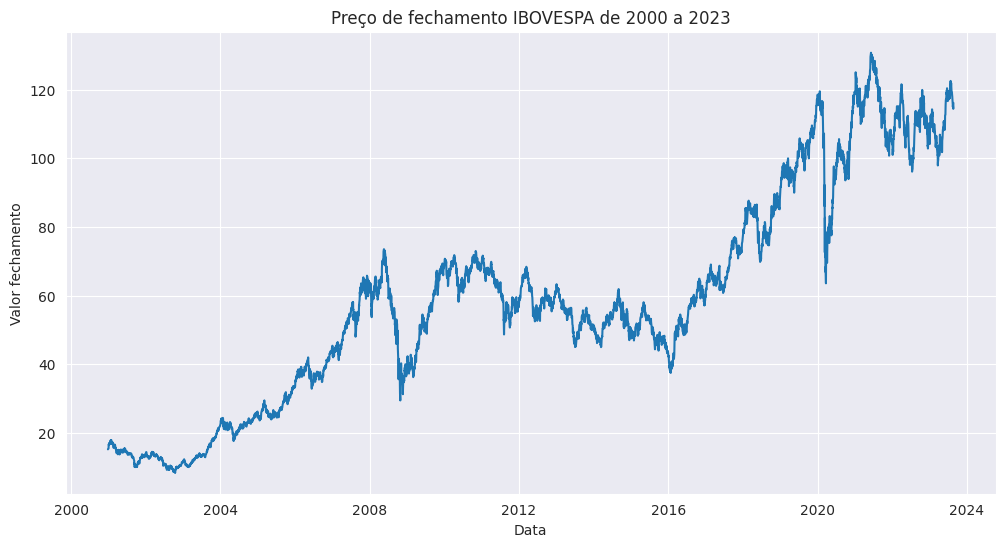

In [27]:
sns.set_style("darkgrid")
ibovespa_diario = ibovespa_diario.sort_index()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_diario.index, ibovespa_diario.Último)
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor fechamento')  # Adiciona rótulo ao eixo y
plt.title('Preço de fechamento IBOVESPA de 2000 a 2023')
plt.show()

**Inferências iniciais sobre a dispersão dos dados ao longo do tempo:**

* Aparentemente, o preço de fechamento da bolsa aumenta ao longo dos anos, com maior amplitude após o ano de 2016.

* No momento atual (Agosto/2023), há um comportamento de leve queda em relação aos períodos anteriores.

* Nas quedas em 2008 e 2020, é possível perceber como fatores externos impactam diretamente na reação do mercado (possíveis outliers)
> **2008:** Os resultados da economia brasileira foram bastante influenciados pela crise financeira internacional em 2009, considerada como a maior crise econômica da história.

    > **2020**: Impacto da pandemia global do Coronavírus.

* Percebemos que os dados sofrem diversas variações ao longo do tempo, mas sem uma sazonalidade muito evidente, consequência da sensibilidade do dado para fotores externos ou incertezas de mercado.


**Análise de dados por dia da semana**

Objetivo: Qual a distrbuiçção por dia e existe uma sazonalidade diária?

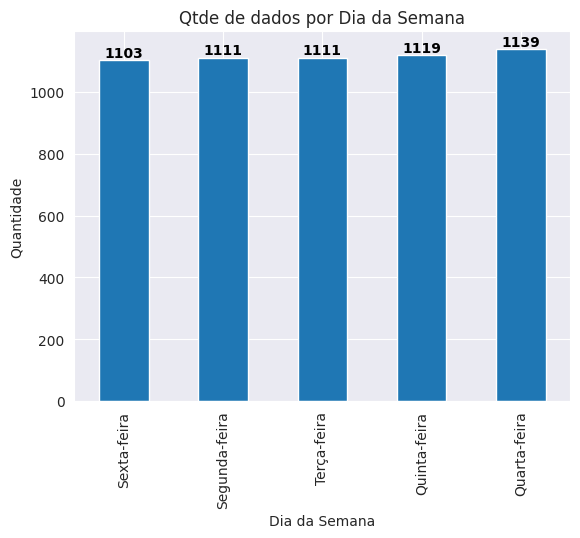

In [28]:
dados_dia = ibovespa_diario.groupby("Dia_da_Semana")["Último"].nunique()
dados_dia.sort_values(ascending=True, inplace=True)
# Criar o gráfico de barras
ax = dados_dia.plot(kind='bar')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Qtde de dados por Dia da Semana')

# Adicionar valores como anotações nas barras
for idx, value in enumerate(dados_dia):
    ax.text(idx, value + 10, str(value), ha='center', color='black', fontweight='bold')

plt.show()

* Há uma concentração linear em relação dias da semana, com quarta-feria sendo o dia com maiores obsevarções desde o começo.

* Aqui, percebemos que o dados captados pela IBOVESPA são relacionados a dias úteis, sem presença de final de semana ou até mesmo feriados.

* Além disso, no gráfico abaixo percebemos que média de pontos do fechamento se mantem ao longo dos dias, sem indicações de fechamentos maiores em algum dia específico.

In [29]:
ibovespa_diario.groupby("Dia_da_Semana")["Último"].describe().round(2).T # avaliação das estatísticas por dia da semana

Dia_da_Semana,Quarta-feira,Quinta-feira,Segunda-feira,Sexta-feira,Terça-feira
count,1142.00,1122.00,1119.00,1110.00,1118.00
mean,58.92,59.01,58.80,58.78,58.84
std,31.03,31.18,31.13,31.09,30.98
min,8.37,8.87,8.45,8.72,8.51
25%,37.70,37.50,37.24,37.34,37.41
50%,56.46,56.79,56.49,56.49,56.24
75%,74.78,74.68,74.32,73.80,74.32
max,129.91,130.08,130.78,130.13,130.09


**Histograma e distribuição dos dados**

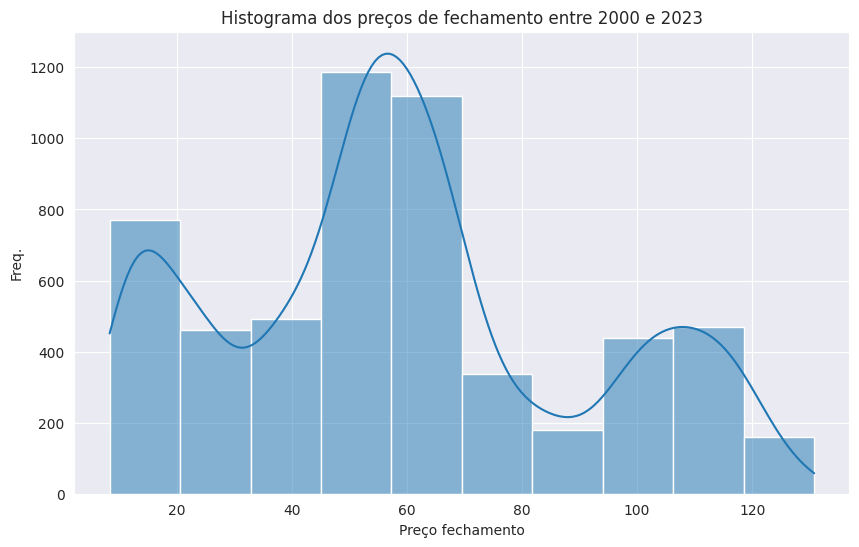

In [30]:
plt.figure(figsize=(10,6))
plot = ibovespa_diario.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2000 e 2023')
plt.show()

A distribuição dos dados indica uma distribuição assimétrica á esquerda, indicando que há uma concentração maior de dados de fechamento até 60.

Pelo gráfico, entendemos que essa concentração de dados ocorre antes do ano de 2016, quando houve o maior crescimento.

### Análise das série temporal e seus componentes: processo de entendimento das características da série temporal da IBOVESPA e análises pertinentes:

* **Decomposição da serie temporal:** Análise dos componentes contidos na série que podem informar padrões de sazonalidade, tendência e amostras aleatórias (resíduos) da série.

* **Autocorrelação (ACF) e Parcial Autocorrelação (PACF): **Permite entender a estrutura temporal dos dados e as correlações diretas e indiretas sobre os períodos. Além de ajudar na modelagem de dados.

* Estacionariedade da série e teste de AdFuller: Uma série estacionária, em termos simples, é uma sequência de dados onde as médias e as características principais permanecem constantes ao longo do tempo, sem tendências claras de crescimento ou declínio. **Pode ser testada estatísticamente pelo Teste ADF (Augmented Dickey-Fuller)**

**Análise do Seasonal Decompose**

In [31]:
# configuralção da decomposição
dados_decompose = ibovespa_diario[['Último']]
dados_decompose = dados_decompose.dropna() # eliminar dados nulos
dados_decompose = dados_decompose.sort_index() # eliminar ordenar as datas em forma crescente

resultados = seasonal_decompose(dados_decompose, period=12, model='multiplicative') # O parâmetro “período” é o número de observações em um ciclo sazonal. 12 considerando a sazonalidade anual

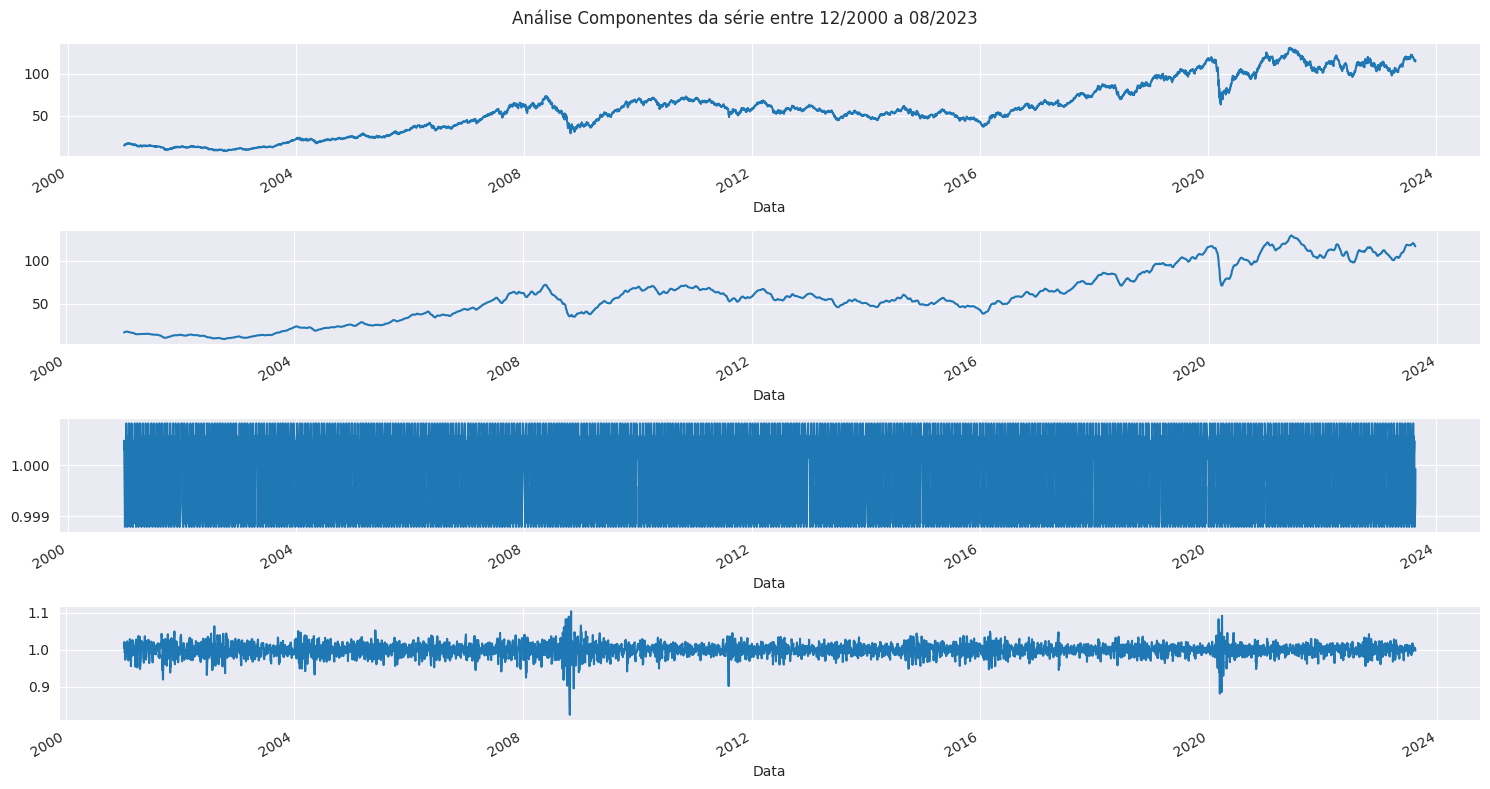

In [32]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
plt.suptitle("Análise Componentes da série entre 12/2000 a 08/2023")
resultados.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [33]:
resultados.resid.to_frame().mean()

resid    0.999884
dtype: float64

> **Inferências iniciais dos gráficos**:

* Pelas análises de obervação e tendência, é possível visualizar um aumento do preço de fechamento ao longo dos anos, com tendência crescente, mas sem sazonalidade aparente.

* Em relação aos ruídos, temos também uma média próxima há 1, indicando que não se trata de um ruído branco (cuja expectativa é zero e possuem variância constante) e podem haver dados nesse componente que poderiam ser usados no nosso modelo.

**Relembrando a distribuição dos dados**

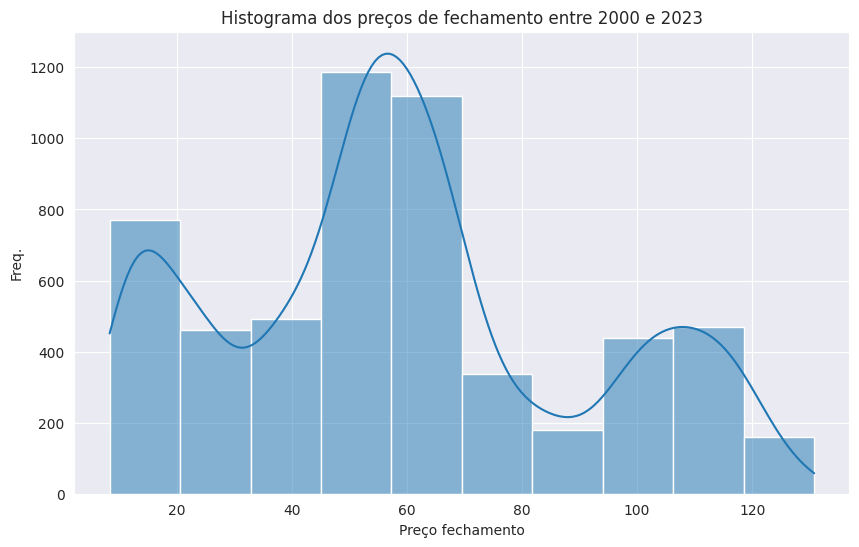

In [34]:
plt.figure(figsize=(10,6))
plot = ibovespa_diario.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2000 e 2023')
plt.show()

* A distribuição aparentemente é assimétrica e não se comporta como uma normal. Vamos testar com o teste de Shapiro-Wilk para avaliação:

* Neste caso, indica a possibilidade no tratamento de dados para remover tendências e padrões sazonais, tornando a série mais estacionária.


In [35]:
from scipy.stats import norm, shapiro # teste de shapiro para análise
shapiro_test = ibovespa_diario['Último']
shapiro(shapiro_test)
alpha = 0.05 # definição da significancia

print(f"\tP-Value Shapiro: {shapiro(shapiro_test).pvalue}")

# avaliação final
print("\n\nAvaliação do p-value:")
if shapiro(shapiro_test).pvalue >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Distribuiçaõ Normal")
else:
  print(f"\tRejeitar a hipótese nula - Diferente de uma distribuição normal.")


	P-Value Shapiro: 6.938094943580391e-39


Avaliação do p-value:
	Rejeitar a hipótese nula - Diferente de uma distribuição normal.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Análise ACF e PACF

Objetivo: Determinar os coeficientes dos modelos de série temporal, além de ajudar a identificar sazonalide e tendência.

**ACF:** Demonstra como um valor em uma série temporal (t-1) se relaciona com outros valores em pontos de tempo anteriores.

**PACF:** Nos ajuda a calcular a correlação direta entre os dois dias, ignorando a influência dos dias intermediários.



> A função de autocorrelação (ACF) nos dará as possíveis ordens do componente de médias móveis (MA) e a função de autocorrelação parcial nos dará as possíveis ordens do compoenente autorregressivo (AR)


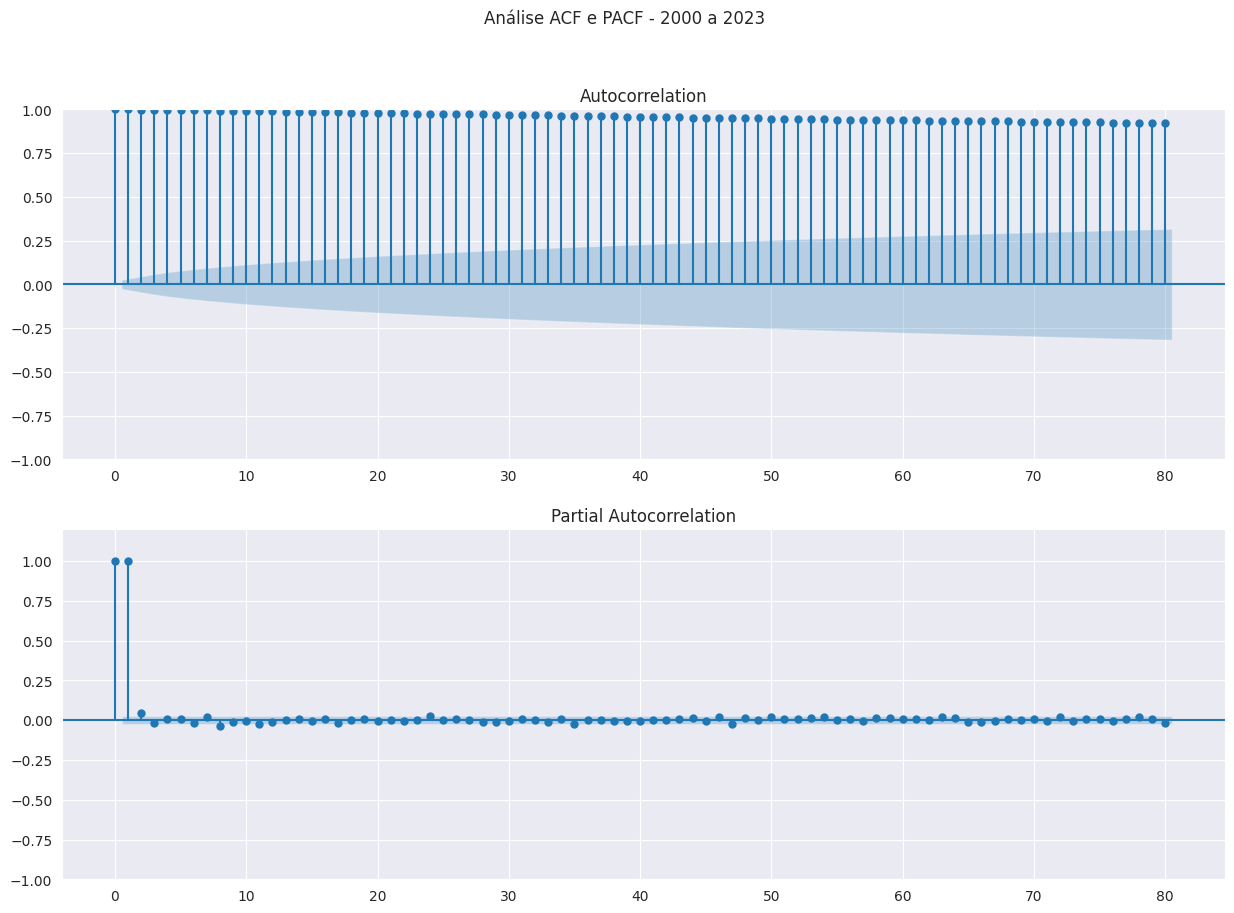

In [36]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
plt.suptitle("Análise ACF e PACF - 2000 a 2023")
plot_acf(ibovespa_diario.Último, ax=ax1, lags=80)
plot_pacf(ibovespa_diario.Último, ax=ax2, lags=80)
plt.ylim(-1,1.2)
# plt.tight_layout()
plt.show()

# Definição e criação dos modelos
> Nesse momento, vamos testar e avaliar o melhor modelo para o nosso objetivo:

* Criar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

* Com acurácia acima de 70%

## 1ª etapa: **Especificando o Baseline (método mais simples)**: Usado como referência para avaliar outros métodos mais complexos
> Baseline atual: O valor de fechamento será baseado no valor anterior - dia anterior

## 2ª Etapa: Preparação das bases

### Dataset 1
* Sem tratamento
* Período da base: 27/12/2000 à 22/08/2023
* Base Treino: 2001-01-04 a 2023-08-13 (653 obs)
* Base Teste: 2023-08-14 a 21/08/2023 (5 obs)

In [37]:
# Criação do dataset
dados_modelo = ibovespa_diario[["Último"]]
dados_modelo["unique_id"] = "ibovespa"
dados_modelo.reset_index(inplace=True)
dados_modelo = dados_modelo.rename(columns={"Data": "ds", "Último": "y"})
dados_modelo.dropna(inplace=True)

# informações gerais da base
print("Data inicial da base:", dados_modelo['ds'].min())
print("Data final da base:", dados_modelo['ds'].max())
print("Tamanho de dados na base:",len(dados_modelo))

Data inicial da base: 2000-12-27 00:00:00
Data final da base: 2023-08-22 00:00:00
Tamanho de dados na base: 5611


<ipython-input-37-c76c7741ebc9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_modelo["unique_id"] = "ibovespa"


In [38]:
# periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
periodo_base = 5 # últimos 3 registros
train, test = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]
h = len(test)

## Print dos dados
print("Dados base treino:")
print("Data inicial:", train["ds"].min())
print("Data final:",train["ds"].max())
print("Tamanho de dados na base:",len(train))

print("\nDados base validação:")
print("Data inicial:", test["ds"].min())
print("Data final:",test["ds"].max())
print("Tamanho de dados na base:",len(test))

Dados base treino:
Data inicial: 2000-12-27 00:00:00
Data final: 2023-08-15 00:00:00
Tamanho de dados na base: 5606

Dados base validação:
Data inicial: 2023-08-16 00:00:00
Data final: 2023-08-22 00:00:00
Tamanho de dados na base: 5


## Baseline com Naive - Sem tratamento


```
WMape Naive: 0.73%
MSE Naive: 77.65%
MAE Naive: 84.33%
RMSE Naive: 88.12%
```



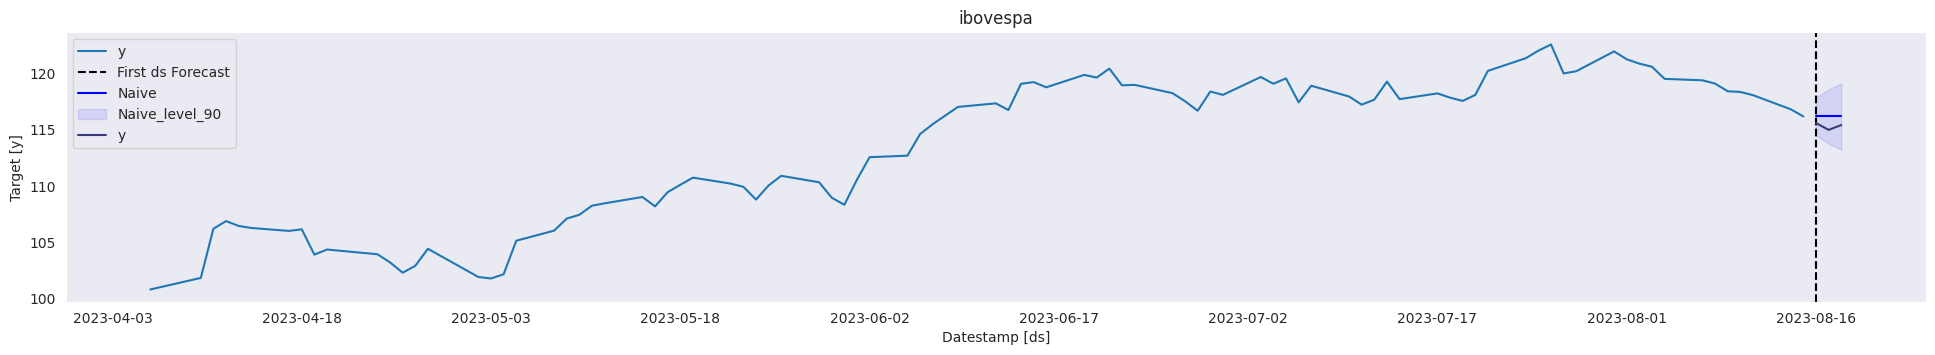

In [39]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train)
forecast_naive = model.predict(h=h, level=[90])
forecast_naive = forecast_naive.reset_index().merge(test, on=['ds', 'unique_id'], how='left').dropna()
model.plot(train, forecast_naive, level=[90], unique_ids=["ibovespa"], max_insample_length=90)

In [40]:
forecast_naive.head

<bound method NDFrame.head of   unique_id         ds       Naive  Naive-lo-90  Naive-hi-90        y
0  ibovespa 2023-08-16  116.170998   114.472870   117.869125  115.592
1  ibovespa 2023-08-17  116.170998   113.769478   118.572517  114.982
2  ibovespa 2023-08-18  116.170998   113.229752   119.112244  115.409>

In [41]:
# Avaliação de resultados Naive com Walk Foward
wmape_naive = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'WMape Naive: {wmape_naive:.2%}')

mse_naive = mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'MSE Naive: {mse_naive:.2%}')

mae_naive = mean_absolute_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'MAE Naive: {mae_naive:.2%}')

rmse_naive = math.sqrt(mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values))
print(f'RMSE Naive: {rmse_naive:.2%}')

WMape Naive: 0.73%
MSE Naive: 77.65%
MAE Naive: 84.33%
RMSE Naive: 88.12%


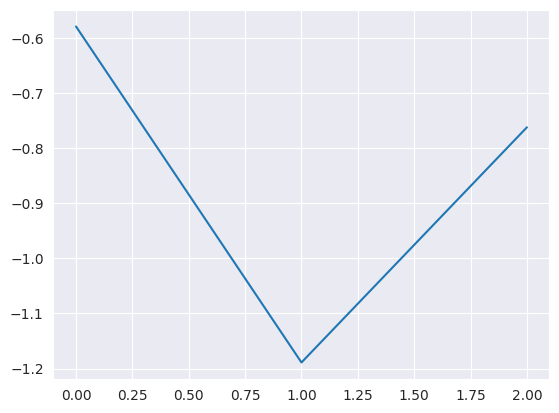

In [42]:
forecast_naive["residual"] = forecast_naive["y"] - forecast_naive["Naive"]
forecast_naive["residual"].plot()
plt.show()

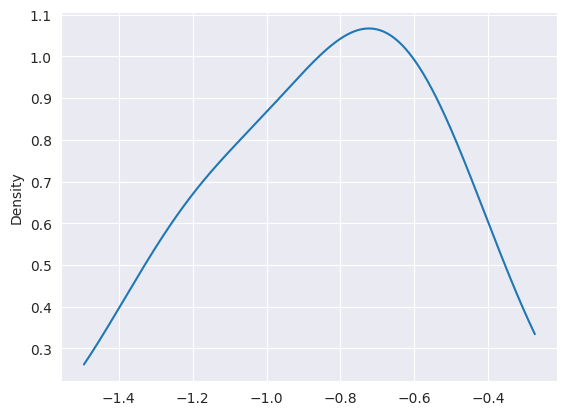

count    3.000000
mean    -0.843331
std      0.313028
min     -1.188998
25%     -0.975498
50%     -0.761998
75%     -0.670498
max     -0.578998
Name: residual, dtype: float64


In [43]:
forecast_naive["residual"].plot(kind='kde')
plt.show()
print(forecast_naive["residual"].describe())

## Insights e descobertas da série temporal:

* Na decomposição da série, vemos que há comportamento de crescimento ao longo dos anos, indicando que há um aumento no volume das cotações em relação à cotação no momento do fechamento.

* A distribuição desses dados apesar de aparentar, não segue uma distribuição normal.

* Não foi possível visualizar facilmente uma tendências ou sazonalidades nos gráficos, uma vez que há um comportamento de alta oscilação.

* Na autocorrelação, temos indícios que a série não é estacionária, já que apresenta uma queda lenta até a correlação 0.

* E pelo teste AdFuller podemos comprovar que a série de dados após 2021 pode ser classificada como **Não Estacionária**

* Após a transformação e diferenciação dos dados, conseguimos tornar a série estacionária e tratar também o ruído, que teve sua média próxima a zero, **indicando se tratar de um white noise**

## Diferenciação da base + Análises

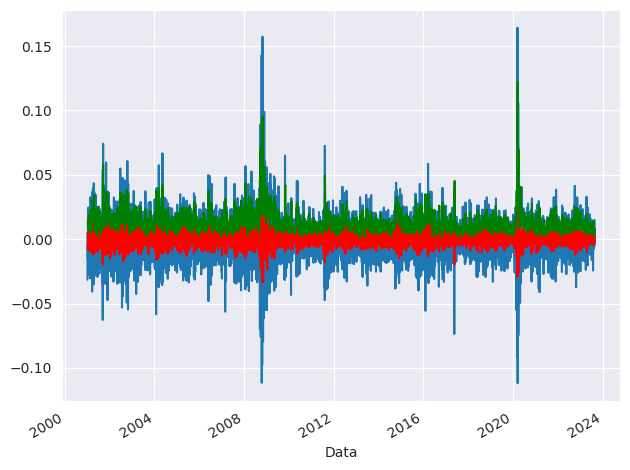

In [45]:
# Tratamento log
df_log = np.log(ibovespa_diario['Último'])
ma_log = df_log.rolling(5).mean()
# f, ax = plt.subplots()
# df_log.plot(ax=ax, legend=False)
# ma_log.plot(ax=ax, legend=False, color='r')
# plt.show()
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(5).mean()
std  = df_s.rolling(5).std()

#diff
dados_decompose_diff = df_s.diff(1)
ma_diff = dados_decompose_diff.rolling(5).mean()
std_diff = dados_decompose_diff.rolling(5).std()

f, ax = plt.subplots()
dados_decompose_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [ ]:
# dados_decompose_diff = dados_decompose.diff(periods=1)
# dados_decompose_diff.plot()

**Análise de AdFuller**

In [46]:
# criação dos parâmetros do modelo
# X_diff = dados_decompose_diff.Último.dropna().values
X_s = df_s.dropna().values
result_s = adfuller(X_s)

# print das métricas do teste
print("Teste ADF - Dados")
print(f"\tTeste Estatístico: {result_s[0]}")
print(f"\tP-Value: {result_s[1]}")
print("\tValores críticos:")

for key, value in result_s[4].items():
  print(f"\t\t{key}: {value}")

# avaliação final
print("\n\nAvaliação do p-value:")
if result_s[1] >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária")
else:
  print(f"\tRejeitar a hipótese nula - Série Estacionária.")

Teste ADF - Dados
	Teste Estatístico: -15.12986982153617
	P-Value: 7.257461708498585e-28
	Valores críticos:
		1%: -3.431521197199818
		5%: -2.862057554466441
		10%: -2.5670454928149486


Avaliação do p-value:
	Rejeitar a hipótese nula - Série Estacionária.


**Análise Autocorrelação**

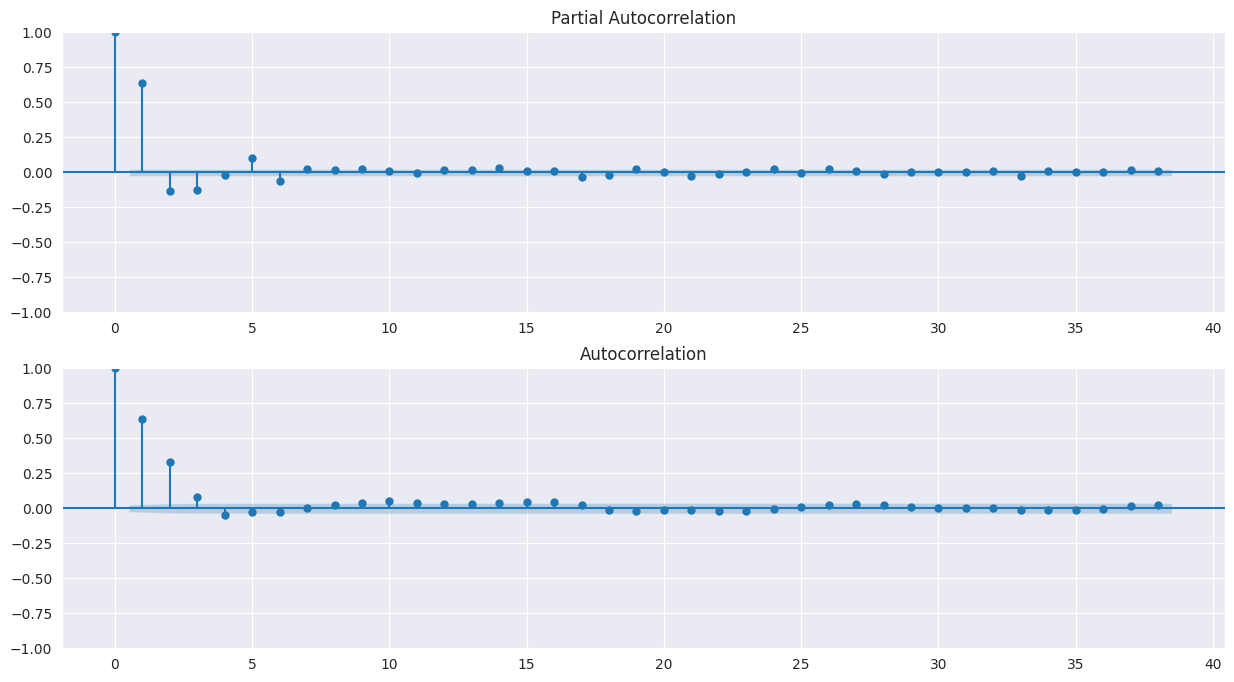

In [47]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,8))
plot_acf(df_s[1:], ax=ax2)
plot_pacf(df_s[1:], ax=ax1)
# plt.ylim(-1,1.2)
# plt.tight_layout()
plt.show()

Após a diferenciação, não há a presença de defasagens estatisticamente significativas, ou seja, não temos indícios de autocorrelação fora do intervalo de confiança gerado nos gráficos.

Isso demonstra que após o processo de diferenciação foram retirados padrões e tendências da série de dados.

In [48]:
# ax = plt.figure(figsize=(10,6))
# ax.suptitle('Autocorrelação Dados Fechamento', fontsize=18) #, x=0.26, y=0.95)
# autocorrelation_plot(df_s[1:]).set_ylim([-0.2, 0.2])
# ax = ax

NameError: ignored

<Figure size 1000x600 with 0 Axes>

**Decomposição da série para visualização dos ruídos**

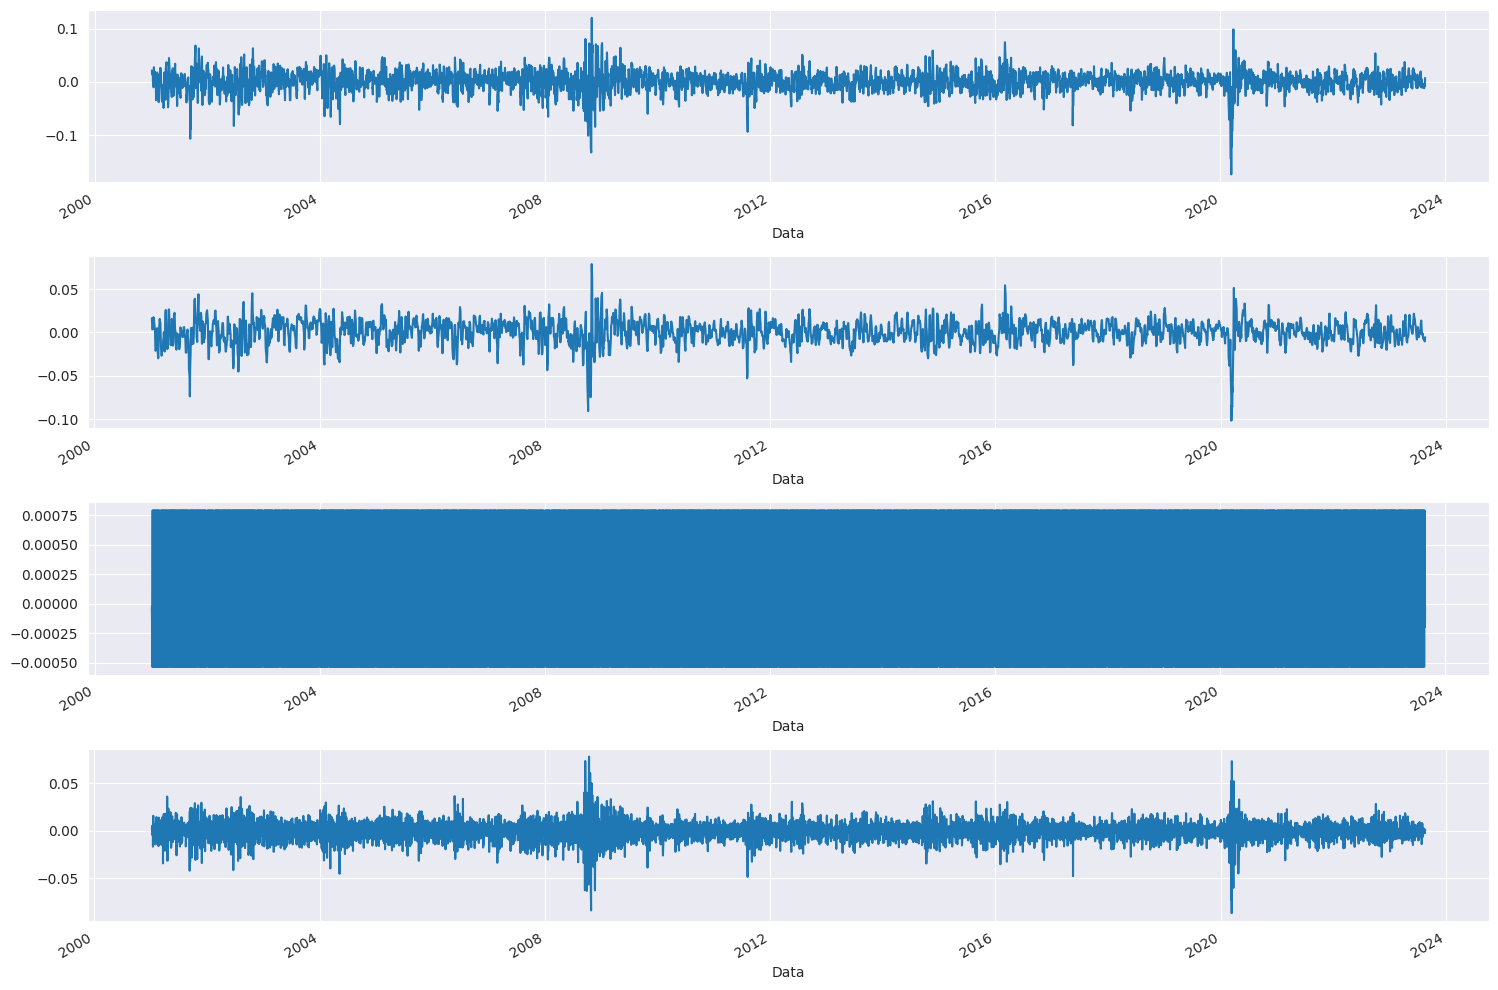

In [49]:
resultado_decompose = seasonal_decompose(df_s[1:], period=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultado_decompose.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultado_decompose.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultado_decompose.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultado_decompose.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [50]:
resultado_decompose.resid.to_frame().mean()

resid   -4.130677e-07
dtype: float64

Com os dados já modificados, é feita criação dos valores de treino na formatação solicitada dos modelos

In [58]:
# Tratamento treino
df_treino_s = df_s.to_frame()
df_treino_s['unique_id'] = 'Ibovespa'
df_treino_s.reset_index(inplace=True)
df_treino_s.rename({'Data':'ds','Último':'y'}, axis=1, inplace=True)
df_treino_s.head()

,ds,y,unique_id
0,2001-01-04,0.052953,Ibovespa
1,2001-01-05,0.021430,Ibovespa
2,2001-01-08,0.014262,Ibovespa
3,2001-01-09,0.019789,Ibovespa
4,2001-01-10,0.012607,Ibovespa


O filtro de tempo que é utilizado para fazer o treinamento do modelo corresponde ao período de 27-12-2000 até 14-08-2023  usar para checagem de predição usamos os 5 próximos dias.

In [59]:
# Filtro validação
# Pegando um periodo de 5 dias

df_valid_s = df_treino_s.loc[(df_treino_s['ds'] >= '2023-08-14') & (df_treino_s['ds'] < '2023-08-21')]
df_treino_s = df_treino_s.loc[df_treino_s['ds'] < '2023-08-14']

## Baseline com HoltWinters

```
WMape Naive: 57.38%
MSE Naive: 0.00%
MAE Naive: 0.67%
RMSE Naive: 0.67%
```

In [60]:
model_hold_winters = StatsForecast(models=[HoltWinters(season_length=5)], freq='B', n_jobs=-1)
model_hold_winters.fit(df_treino_s)

forecast_df_holt = model_hold_winters.predict(h=h, level=[90])
forecast_df_holt = forecast_df_holt.reset_index().merge(df_valid_s, on=['ds'], how='left')

wmape_auto_holt = wmape(forecast_df_holt['y'].values, forecast_df_holt['HoltWinters'].values)

print(f'{(1 - wmape_auto_holt):.2%}')

50.86%


In [ ]:
# Gráfico

In [ ]:
# WMAPE

## Baseline com Naive - Com tratamento

```
WMape Naive: 57.38%
MSE Naive: 0.00%
MAE Naive: 0.67%
RMSE Naive: 0.67%
```



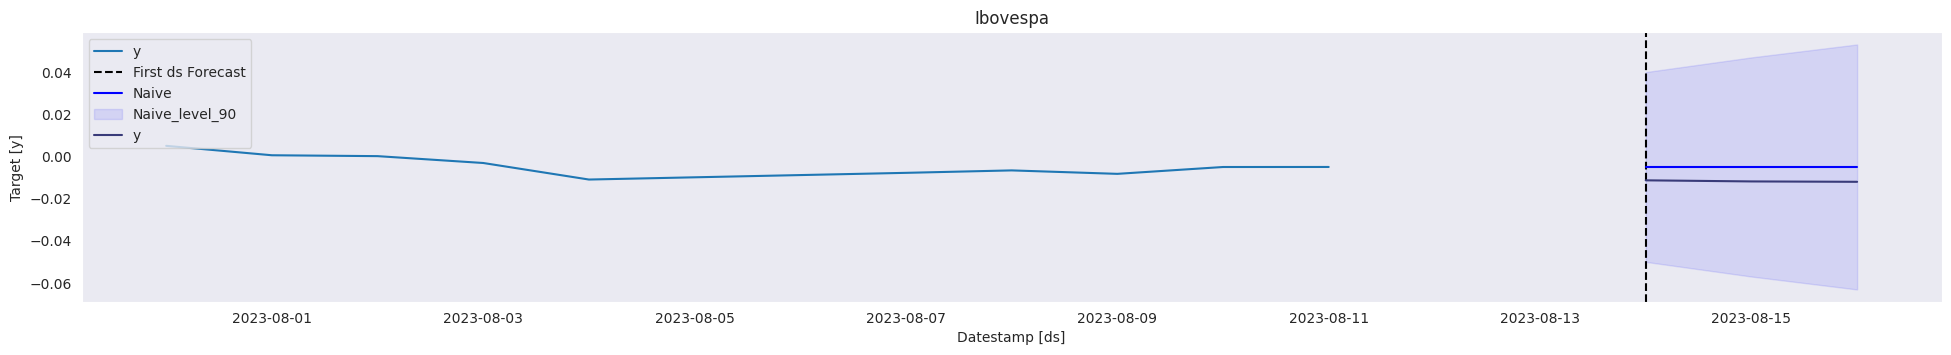

In [101]:
model_trat = StatsForecast(models=[Naive()], freq='d', n_jobs=-1)
model_trat.fit(df_treino_s)

forecast_naive = model_trat.predict(h=5, level=[90])

forecast_naive = forecast_naive.reset_index().merge(df_valid_s, on=['ds'], how='left').dropna()
forecast_naive.rename({'unique_id_x':'unique_id'}, axis=1, inplace=True)
model_trat.plot(df_treino_s, forecast_naive, level=[90], unique_ids=["Ibovespa"], max_insample_length=10)

In [102]:
# Avaliação de resultados Naive com Walk Foward
wmape_naive = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'WMape Naive: {wmape_naive:.2%}')

mse_naive = mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'MSE Naive: {mse_naive:.2%}')

mae_naive = mean_absolute_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'MAE Naive: {mae_naive:.2%}')

rmse_naive = math.sqrt(mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values))
print(f'RMSE Naive: {rmse_naive:.2%}')

WMape Naive: 57.38%
MSE Naive: 0.00%
MAE Naive: 0.67%
RMSE Naive: 0.67%


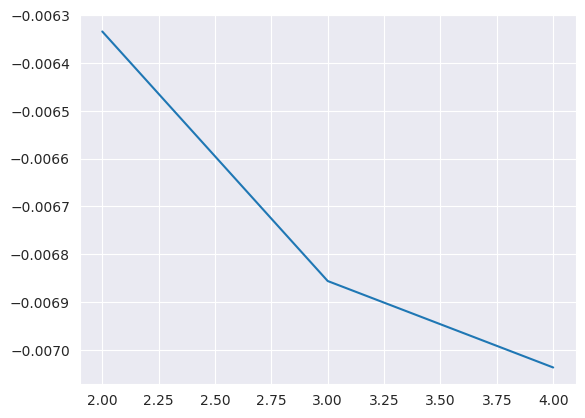

In [103]:
forecast_naive["residual"] = forecast_naive["y"] - forecast_naive["Naive"]
forecast_naive["residual"].plot()
plt.show()

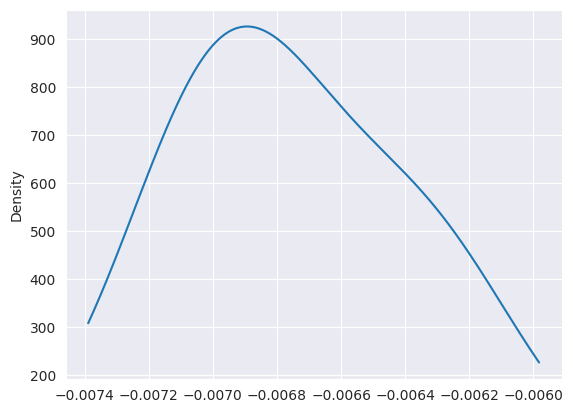

count    3.000000
mean    -0.006742
std      0.000365
min     -0.007037
25%     -0.006947
50%     -0.006856
75%     -0.006595
max     -0.006334
Name: residual, dtype: float64


In [104]:
forecast_naive["residual"].plot(kind='kde')
plt.show()
print(forecast_naive["residual"].describe())

## SeasonalNaive: Baseline com sazonalidade - Tratados

```
WMape Season Naive: 48.07%
MSE Season Naive: 0.00%
MAE Season Naive: 0.56%
RMSE Season Naive: 0.59%
```



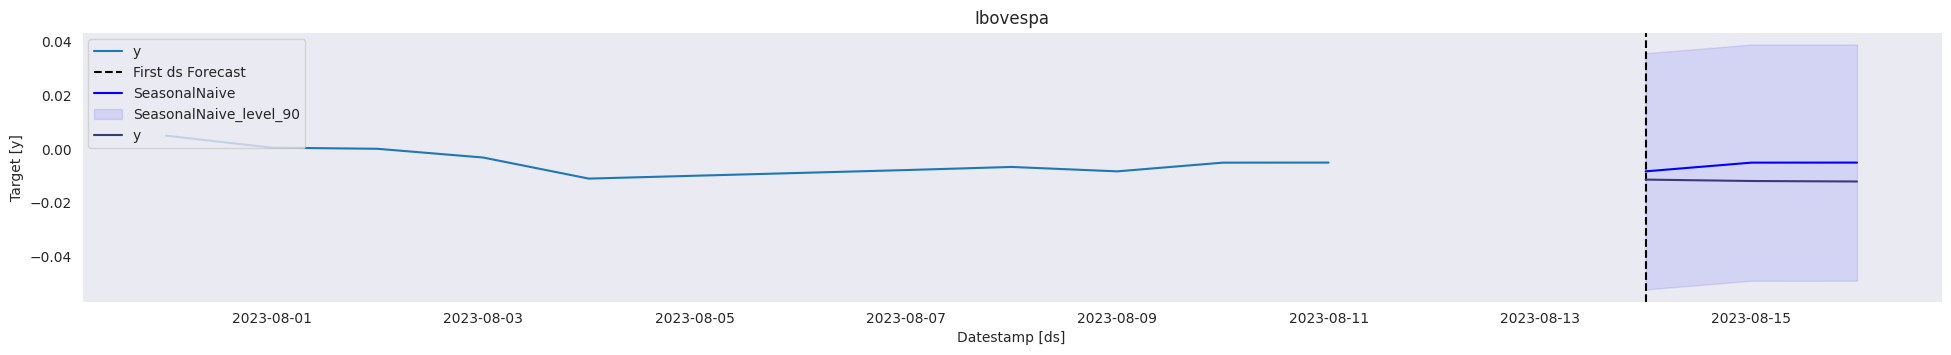

In [97]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=5)], freq='d', n_jobs=-1)
model_s.fit(df_treino_s)

forecast_naives = model_s.predict(h=5, level=[90])
forecast_naives = forecast_naives.reset_index().merge(df_valid_s, on=['ds'], how='left').dropna()
forecast_naives.rename({'unique_id_x':'unique_id'}, axis=1, inplace=True)
model_s.plot(df_treino_s, forecast_naives, level=[90], unique_ids=["Ibovespa"], max_insample_length=10)

In [86]:
# Avaliação de resultados Naive com Walk Foward
wmape_naives = wmape(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values)
print(f'WMape Season Naive: {wmape_naives:.2%}')

mse_naives = mean_squared_error(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values)
print(f'MSE Season Naive: {mse_naives:.2%}')

mae_naives = mean_absolute_error(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values)
print(f'MAE Season Naive: {mae_naives:.2%}')

rmse_naives = math.sqrt(mean_squared_error(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values))
print(f'RMSE Season Naive: {rmse_naives:.2%}')

WMape Season Naive: 48.07%
MSE Season Naive: 0.00%
MAE Season Naive: 0.56%
RMSE Season Naive: 0.59%


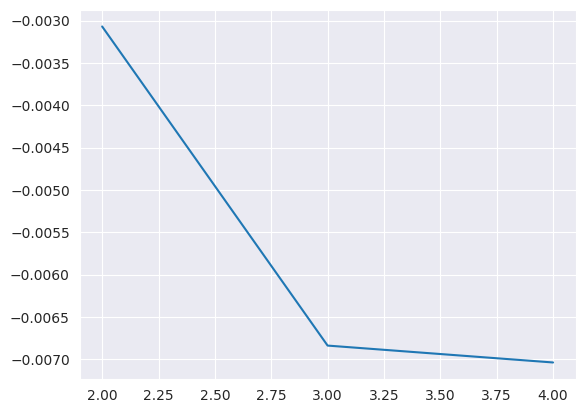

In [72]:
forecast_naives["residual"] = forecast_naives["y"] - forecast_naives["SeasonalNaive"]
forecast_naives["residual"].plot()
plt.show()

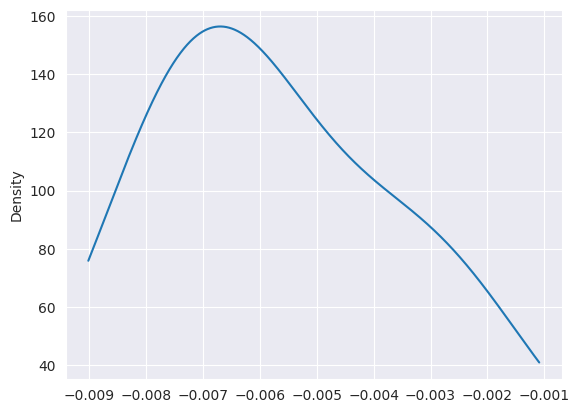

count    3.000000
mean    -0.005648
std      0.002235
min     -0.007037
25%     -0.006937
50%     -0.006838
75%     -0.004954
max     -0.003070
Name: residual, dtype: float64


In [73]:
forecast_naives["residual"].plot(kind='kde')
plt.show()
print(forecast_naives["residual"].describe())

## Modelo com AutoARIMA

```
WMape Arima: 92.78%
MSE Arima: 0.01%
MAE Arima: 0.93%
RMSE Arima: 0.99%
```



In [105]:
model_arima = StatsForecast(models=[AutoARIMA(season_length=12)], freq='B', n_jobs=-1)
model_arima.fit(df_treino_s)

forecast_arima = model_arima.predict(h=h, level=[90])
forecast_arima = forecast_arima.reset_index().merge(df_valid_s, on=['ds'], how='left').dropna()
forecast_arima.rename({'unique_id_x':'unique_id'}, axis=1, inplace=True)
model_arima.plot(df_valid_s, forecast_arima, level=[90], unique_ids=["ibovespa"], max_insample_length=10)

KeyboardInterrupt: ignored

In [76]:
# Avaliação de resultados Naive com Walk Foward
wmape_arima = wmape(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
print(f'WMape Arima: {wmape_arima:.2%}')

mse_arima = mean_squared_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
print(f'MSE Arima: {mse_arima:.2%}')

mae_arima = mean_absolute_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
print(f'MAE Arima: {mae_arima:.2%}')

rmse_arima = math.sqrt(mean_squared_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values))
print(f'RMSE Arima: {rmse_arima:.2%}')

WMape Arima: 92.78%
MSE Arima: 0.01%
MAE Arima: 0.93%
RMSE Arima: 0.99%


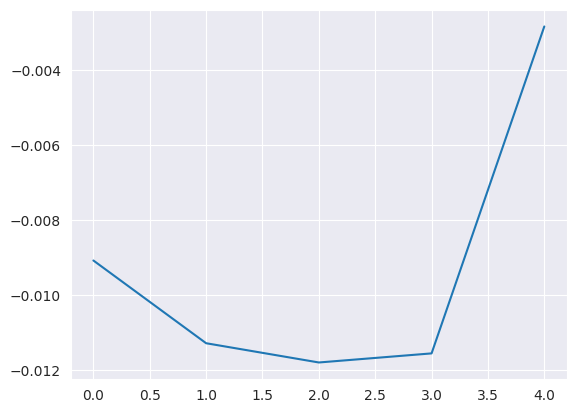

In [77]:
forecast_arima["residual"] = forecast_arima["y"] - forecast_arima["AutoARIMA"]
forecast_arima["residual"].plot()
plt.show()

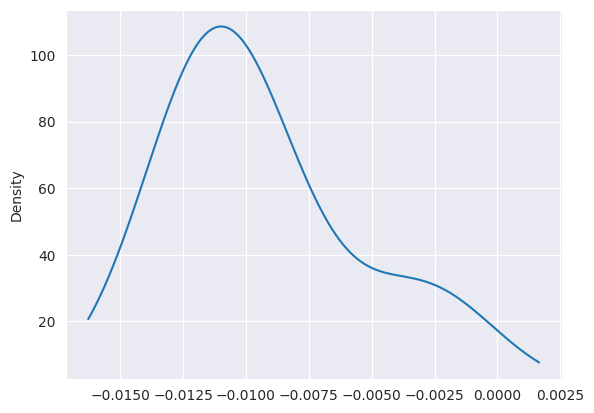

count    5.000000
mean    -0.009300
std      0.003778
min     -0.011787
25%     -0.011545
50%     -0.011274
75%     -0.009068
max     -0.002826
Name: residual, dtype: float64


In [78]:
forecast_arima["residual"].plot(kind='kde')
plt.show()
print(forecast_arima["residual"].describe())

## Modelo Auto ETS


```
WMape Auto ETS: 56.67%
MSE Auto ETS: 0.00%
MAE Auto ETS: 0.57%
RMSE Auto ETS: 0.60%
```



In [63]:
#autoETS

model_auto_ets = StatsForecast(models=[AutoETS(season_length=5, model='AAZ')], freq='B',n_jobs=-1)
model_auto_ets.fit(df_treino_s)

forecast_dfa = model_auto_ets.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(df_valid_s, on=['ds', 'unique_id'], how='left').dropna()
#model_auto_ets.plot(df_valid_s, forecast_dfa, level=[90], unique_ids=["ibovespa"], max_insample_length=90)

In [64]:
# Avaliação de resultados Naive com Walk Foward
wmape_ets = wmape(forecast_dfa['y'].values, forecast_dfa['AutoETS'].values)
print(f'WMape Auto ETS: {wmape_ets:.2%}')

mse_ets = mean_squared_error(forecast_dfa['y'].values, forecast_dfa['AutoETS'].values)
print(f'MSE Auto ETS: {mse_ets:.2%}')

mae_ets = mean_absolute_error(forecast_dfa['y'].values, forecast_dfa['AutoETS'].values)
print(f'MAE Auto ETS: {mae_ets:.2%}')

rmse_ets = math.sqrt(mean_squared_error(forecast_dfa['y'].values, forecast_dfa['AutoETS'].values))
print(f'RMSE Auto ETS: {rmse_ets:.2%}')

WMape Auto ETS: 56.67%
MSE Auto ETS: 0.00%
MAE Auto ETS: 0.57%
RMSE Auto ETS: 0.60%


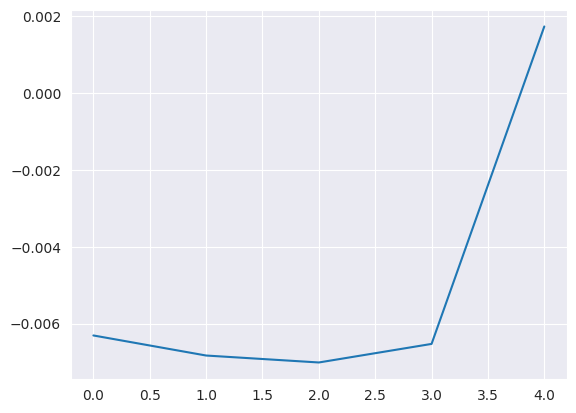

In [65]:
forecast_dfa["residual"] = forecast_dfa["y"] - forecast_dfa["AutoETS"]
forecast_dfa["residual"].plot()
plt.show()

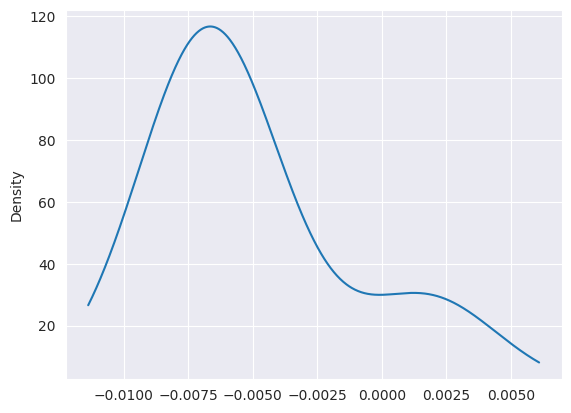

count    5.000000
mean    -0.004988
std      0.003766
min     -0.007010
25%     -0.006829
50%     -0.006527
75%     -0.006307
max      0.001731
Name: residual, dtype: float64


In [66]:
forecast_dfa["residual"].plot(kind='kde')
plt.show()
print(forecast_dfa["residual"].describe())